# Bayesian Networks in Python

In this tutorial, we will explore how to use Bayesian networks in Python using the `pgmpy` library.

See documentation at:
- https://pgmpy.org/
- https://pgmpy.org/models/bayesiannetwork.html
- https://pgmpy.org/factors/discrete.html
- https://pgmpy.org/exact_infer/ve.html

## Implementation in Python using `pgmpy`.

Let's start by installing the `pgmpy` library.

In [2]:
!pip install -q pgmpy networkx matplotlib plotly daft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.4 MB/s eta 0:00:00


Import the required libraries.

In [3]:
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt

Create the Bayesian network:

+--------------------+------+
| TrainStrike(True)  | 0.05 |
+--------------------+------+
| TrainStrike(False) | 0.95 |
+--------------------+------+
+-------------------------+-----+
| PetersAlarmFails(True)  | 0.1 |
+-------------------------+-----+
| PetersAlarmFails(False) | 0.9 |
+-------------------------+-----+
+------------------+-----+-------------------------+
| TrainStrike      | ... | TrainStrike(False)      |
+------------------+-----+-------------------------+
| PetersAlarmFails | ... | PetersAlarmFails(False) |
+------------------+-----+-------------------------+
| PeterLate(True)  | ... | 0.01                    |
+------------------+-----+-------------------------+
| PeterLate(False) | ... | 0.99                    |
+------------------+-----+-------------------------+
+--------------------+-------------------+--------------------+
| TrainStrike        | TrainStrike(True) | TrainStrike(False) |
+--------------------+-------------------+--------------------+
| JohannaLa

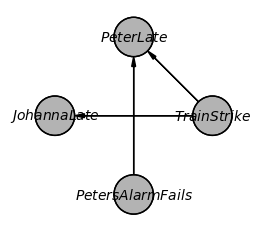

In [8]:
# Define the network structure
model = BayesianNetwork([('TrainStrike', 'PeterLate'), ('TrainStrike', 'JohannaLate'),
                         ('PetersAlarmFails', 'PeterLate')])

statenames = {'TrainStrike': ['True', 'False'],
              'PeterLate': ['True', 'False'],
              'JohannaLate': ['True', 'False'],
              'PetersAlarmFails': ['True', 'False']}

model.to_daft().render()

# for each variable add a tabular conditional probability distribution 
model.add_cpds(
  TabularCPD(
      variable='TrainStrike', 
      variable_card=2,
      values=[[0.05], [0.95]],
      state_names=statenames),
  TabularCPD(
      variable='PetersAlarmFails', 
      variable_card=2,
      values=[[0.1], [0.9]],
      state_names=statenames),
  TabularCPD(
      variable='PeterLate', 
      variable_card=2,
      evidence=['TrainStrike', 'PetersAlarmFails'], 
      evidence_card=[2,2],
      values = [[0.7, 0.3, 0.4, 0.01],
                [0.3, 0.7, 0.6, 0.99]],
      state_names=statenames),
  TabularCPD(
      variable='JohannaLate', 
      variable_card=2,
      evidence=['TrainStrike'], evidence_card=[2],
      values = [[0.5, 0.02],
                [0.5, 0.98]],
      state_names=statenames),
)

# print the conditional probability distributions
for cpd in model.get_cpds():
  print(cpd)

Default - keine Änderungen
> Eingerückter Textblock



In [15]:
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)

print(inference.query(variables=['JohannaLate']))
print(inference.query(variables=['PeterLate']))

+--------------------+--------------------+
| JohannaLate        |   phi(JohannaLate) |
+====================+====================+
| JohannaLate(True)  |             0.0440 |
+--------------------+--------------------+
| JohannaLate(False) |             0.9560 |
+--------------------+--------------------+
+------------------+------------------+
| PeterLate        |   phi(PeterLate) |
+==================+==================+
| PeterLate(True)  |           0.0635 |
+------------------+------------------+
| PeterLate(False) |           0.9365 |
+------------------+------------------+


Wahrscheinlichkeit, dass Johanna zu spät kommt, falls Peters Wecker nicht klingelt -> Keine Auswirkung auf Johanna

In [10]:
evidence={'PetersAlarmFails':'True'}
result = inference.query(variables=['JohannaLate'], evidence=evidence)
print(evidence)
print(result)

{'PetersAlarmFails': 'True'}
+--------------------+--------------------+
| JohannaLate        |   phi(JohannaLate) |
+====================+====================+
| JohannaLate(True)  |             0.0440 |
+--------------------+--------------------+
| JohannaLate(False) |             0.9560 |
+--------------------+--------------------+


Wahrscheinlichkeit, dass Johanna zu spät kommt, falls Peters zu spät kommt -> 15% (steigt, weil auch die Wahrscheinlichkeit steigt, dass ein Bahnstreik die Ursache für Peters Zuspätkommen ist)

In [17]:
evidence={'PeterLate':'True'}
result = inference.query(variables=['JohannaLate'], evidence=evidence)
print(evidence)
print(result)

{'PeterLate': 'True'}
+--------------------+--------------------+
| JohannaLate        |   phi(JohannaLate) |
+====================+====================+
| JohannaLate(True)  |             0.1484 |
+--------------------+--------------------+
| JohannaLate(False) |             0.8516 |
+--------------------+--------------------+


Wahrscheinlichkeit, dass Johanna zu spät kommt, falls Peters zu spät kommt -> 6% - steigt, weil auch die Wahrscheinlichkeit steigt, dass ein Bahnstreik die Ursache für Peters Zuspätkommen ist (aber nicht so stark wie im vorangegangenen Beispiel, da Peters Wecker auch ausgefallen ist und daher die Wahrscheinlichkeit, dass der Zug Verspätung hat geringer ist.)

In [18]:
evidence={'PeterLate':'True', 'PetersAlarmFails': 'True'}
result = inference.query(variables=['JohannaLate'], evidence=evidence)
print(evidence)
print(result)

{'PeterLate': 'True', 'PetersAlarmFails': 'True'}
+--------------------+--------------------+
| JohannaLate        |   phi(JohannaLate) |
+====================+====================+
| JohannaLate(True)  |             0.0605 |
+--------------------+--------------------+
| JohannaLate(False) |             0.9395 |
+--------------------+--------------------+
